In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import os

In [25]:
# hyper-parameters
NUM_CLASSES = 2
CHANNELS = 3
IMAGE_RESIZE = 224
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
BATCH_SIZE_TESTING = 1
MODEL_NAME = 'best_model.h5'

In [26]:
from keras.applications import ResNet50,
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
# create model
model = Sequential()

base_model = ResNet50(input_shape=(IMAGE_RESIZE,IMAGE_RESIZE,3),
                      include_top=False, pooling='avg')
model.add(base_model)
model.add(Dense(2, activation='softmax'))

model.layers[0].trainable= False

94658560/94653016 [==============================] - 359s 4us/step


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [13]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_directory("./trainvalidfull4keras/train",
                                                    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
                                                    batch_size=BATCH_SIZE_TRAINING,
                                                    class_mode='categorical')
valid_generator = data_generator.flow_from_directory(".//trainvalidfull4keras/valid",
                                                    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
                                                    batch_size=BATCH_SIZE_VALIDATION,
                                                    class_mode='categorical')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
early_stopper = EarlyStopping(monitor='val_loss',
                             patience=EARLY_STOP_PATIENCE,
                             verbose=1)
checkpointer = ModelCheckpoint(filepath=MODEL_NAME,
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1)

In [15]:
if os.path.exists(MODEL_NAME):
    model.load_weights(MODEL_NAME)
else:
    model_history = model.fit_generator(
                train_generator,
                steps_per_epoch=20000//BATCH_SIZE_TRAINING,
                epochs=NUM_EPOCHS,
                validation_data= valid_generator,
                validation_steps = 20,
                callbacks=[checkpointer, early_stopper],
                workers=10
    )

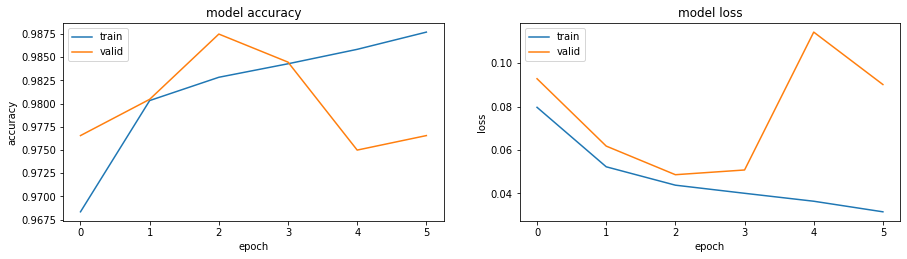

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(model_history.history['acc'])  
plt.plot(model_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(model_history.history['loss'])  
plt.plot(model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [18]:
test_generator = data_generator.flow_from_directory(
    directory = 'test_',
    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 54 images belonging to 1 classes.


In [19]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

54/54 [==============================] - 27s 504ms/step


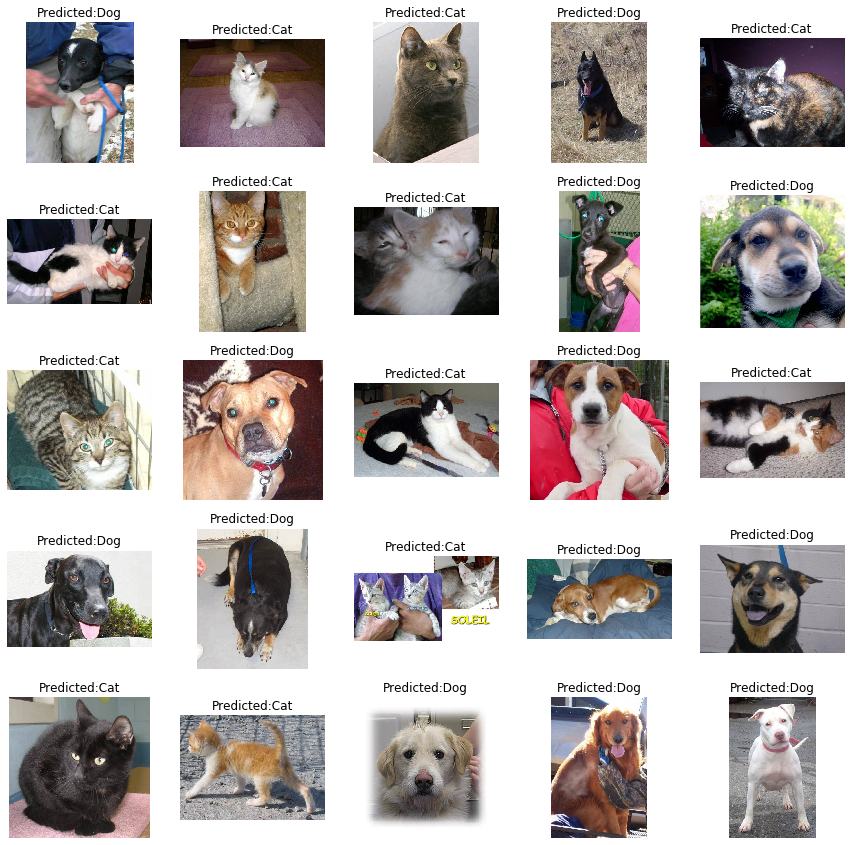

In [23]:
TEST_DIR = 'test_\\'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(25):
    img_BGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(img_RGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

Source Address:
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50

*:)*